In [2]:
import numpy as np
import pandas as pd 
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot') 

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader


from sklearn.model_selection import RandomizedSearchCV 
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn import metrics 
import os
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


data = pd.read_csv('UCI_Credit_Card.csv', delimiter = ',')
data_rec = pd.DataFrame()

In [3]:
dist_names = ['norm',
              'exponweib',
              'chi2',
              'lognorm',
              'beta',
              'cauchy',
              'cosine',
              'gamma',
              'logistic',
              'lomax',
              'maxwell',
              'rdist',
              'uniform', 
              'erlang']


In [29]:
for i in range(0,len(data.columns)):
        print("column:", i+1)
        #standardization 
        s_data = data[data.columns[i]]
        scaled = ((s_data-s_data.mean())/s_data.std())
        y_std= scaled
        emperical = [(1 + k) / len(y_std) for k in range(len(y_std))]# for ecdf
        t = np.linspace(min(y_std), max(y_std),30000)
        
        #batching data in sets of 100
        data_batch = DataLoader(data[data.columns[i]], batch_size=100, shuffle = False)
        p_val = [0] * len(data_batch)
        q_val = [''] * len(data_batch)
        D_val = [0] * len(data_batch)
        j=0;
        temp_col = []
        for dat in data_batch: 
            dat = dat.numpy()
            dt = (dat - dat.mean())/dat.std()
            #distribution assignment
            for distribution in dist_names:
                dist = getattr(stats, distribution)
                #dat1 = dat.astype('int32')
                try:
                    param = dist.fit(dat) #parameter fitting for ks test
                except ValueError:
                    continue
                    
 
                
                d,p = stats.kstest(dat, distribution, args=param)
                if p_val[j]<p:
                    p_val[j] = p
                    D_val[j] = d
                    q_val[j] = distribution
            param1 = getattr(scipy.stats,q_val[j] ).fit(dat) #parameter fitting for recreation
            temp = getattr(scipy.stats, q_val[j]).rvs(*param1[:-2], loc=param1[-2], scale=param1[-1], size = 100)
            
            #ordering data as per the original data order
            sort_temp = np.sort(temp)
            idx = np.argsort(dat)
            b_new = [0]*len(sort_temp)
           
            for index in range(0,len(sort_temp)):
                b_new[idx[index]] = sort_temp[index] 
                
            temp_col = np.append(temp_col, b_new)
            j+=1
            #break
        data_rec[data.columns[i]] = temp_col
            
        #break

column: 1
column: 2
column: 3
column: 4
column: 5
column: 6
column: 7
column: 8
column: 9
column: 10
column: 11
column: 12
column: 13
column: 14
column: 15
column: 16
column: 17
column: 18
column: 19
column: 20
column: 21
column: 22
column: 23
column: 24
column: 25


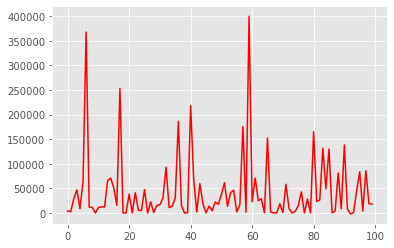

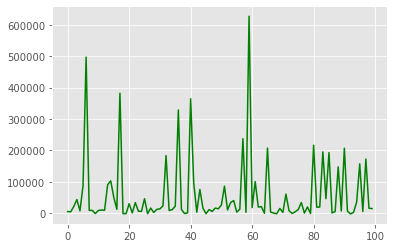

In [26]:
#plotting the batch of data
plt.plot(data[data.columns[i]][:100],color = 'r')

plt.show()

plt.plot(data_rec[data.columns[i]][:100], color = 'g')

plt.show()

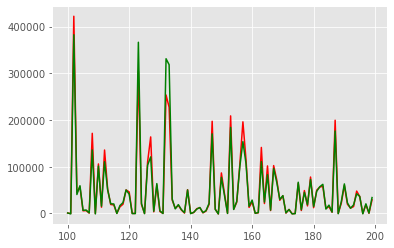

In [28]:
plt.plot(data[data.columns[i]][100:200],color = 'r')
plt.plot(data_rec[data.columns[i]][100:200], color = 'g')
plt.show()

In [30]:
data_rec.rename(columns={"default.payment.next.month": "Default"}, inplace=True)
data_rec["Default"] = data["default.payment.next.month"]
data.rename(columns={"default.payment.next.month": "Default"}, inplace=True)
data.drop('ID', axis = 1, inplace =True)
data_rec.drop('ID', axis = 1, inplace =True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  30000 non-null  float64
 1   SEX        30000 non-null  int64  
 2   EDUCATION  30000 non-null  int64  
 3   MARRIAGE   30000 non-null  int64  
 4   AGE        30000 non-null  int64  
 5   PAY_0      30000 non-null  int64  
 6   PAY_2      30000 non-null  int64  
 7   PAY_3      30000 non-null  int64  
 8   PAY_4      30000 non-null  int64  
 9   PAY_5      30000 non-null  int64  
 10  PAY_6      30000 non-null  int64  
 11  BILL_AMT1  30000 non-null  float64
 12  BILL_AMT2  30000 non-null  float64
 13  BILL_AMT3  30000 non-null  float64
 14  BILL_AMT4  30000 non-null  float64
 15  BILL_AMT5  30000 non-null  float64
 16  BILL_AMT6  30000 non-null  float64
 17  PAY_AMT1   30000 non-null  float64
 18  PAY_AMT2   30000 non-null  float64
 19  PAY_AMT3   30000 non-null  float64
 20  PAY_AM

In [33]:
y = data.Default     # target default=1 or non-default=0
features = data.drop('Default', axis = 1, inplace = False)
data['EDUCATION']=np.where(data['EDUCATION'] == 5, 4, data['EDUCATION'])
data['EDUCATION']=np.where(data['EDUCATION'] == 6, 4, data['EDUCATION'])
data['EDUCATION']=np.where(data['EDUCATION'] == 0, 4, data['EDUCATION'])
data['MARRIAGE']=np.where(data['MARRIAGE'] == 0, 3, data['MARRIAGE'])
data['MARRIAGE'].unique()


In [35]:
# Original data
X = data.drop('Default', axis=1)  
y = data['Default']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)


#searching for best suited parametrs for RF classifier
param_dist = {'n_estimators': [50,100,150,200,250],
               "max_features": [1,2,3,4,5,6,7,8,9],
               'max_depth': [1,2,3,4,5,6,7,8,9],
               "criterion": ["gini", "entropy"]}

rf = RandomForestClassifier()

rf_cv = RandomizedSearchCV(rf, param_distributions = param_dist, 
                           cv = 5, random_state=0, n_jobs = -1)

rf_cv.fit(X, y)

print("Tuned Random Forest Parameters: %s" % (rf_cv.best_params_))

Tuned Random Forest Parameters: {'n_estimators': 200, 'max_features': 6, 'max_depth': 5, 'criterion': 'entropy'}


Accuracy: 0.8171666666666667

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.66      0.35      0.46      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.67      6000
weighted avg       0.80      0.82      0.79      6000


Average 5-Fold CV Score: 0.8203 , Standard deviation: 0.0093


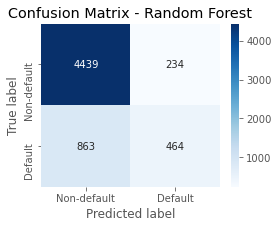

In [36]:
Ran = RandomForestClassifier(criterion= 'gini', max_depth= 6, 
                                     max_features= 5, n_estimators= 150, 
                                     random_state=0)
Ran.fit(X_train, y_train)
y_pred = Ran.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_pred,y_test))

## 5-fold cross-validation 
cv_scores =cross_val_score(Ran, X, y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_test, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,Ran.predict(X_test))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Random Forest");

In [40]:
#training and splitting the recreated data
X = data_rec.drop('Default', axis=1)  
y = data_rec['Default']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)



param_dist = {'n_estimators': [50,100,150,200,250],
               "max_features": [1,2,3,4,5,6,7,8,9],
               'max_depth': [1,2,3,4,5,6,7,8,9],
               "criterion": ["gini", "entropy"]}

rf = RandomForestClassifier()

rf_cv = RandomizedSearchCV(rf, param_distributions = param_dist, 
                           cv = 5, random_state=0, n_jobs = -1)

rf_cv.fit(X, y)

print("Tuned Random Forest Parameters: %s" % (rf_cv.best_params_))

Tuned Random Forest Parameters: {'n_estimators': 150, 'max_features': 5, 'max_depth': 6, 'criterion': 'gini'}


Accuracy: 0.8103333333333333

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      4673
           1       0.65      0.31      0.42      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.63      0.65      6000
weighted avg       0.79      0.81      0.78      6000


Average 5-Fold CV Score: 0.8129 , Standard deviation: 0.0069


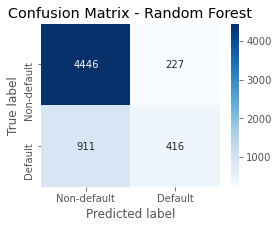

In [41]:
Ran = RandomForestClassifier(criterion= 'gini', oob_score = True, max_depth= 5, 
                                     max_features= 6, n_estimators= 200, 
                                     random_state=0)
Ran.fit(X_train, y_train)
y_pred = Ran.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_pred,y_test))

## 5-fold cross-validation 
cv_scores =cross_val_score(Ran, X, y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_test, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,Ran.predict(X_test))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Random Forest");

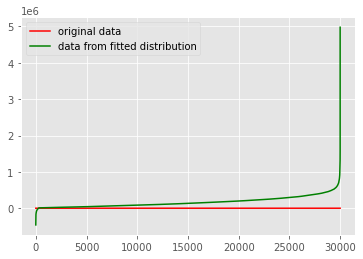

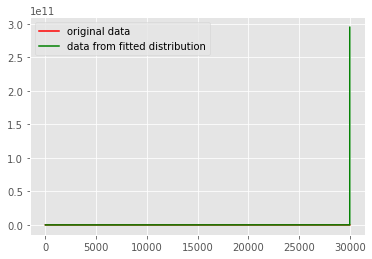

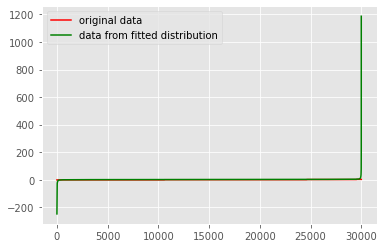

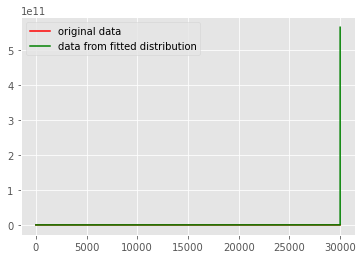

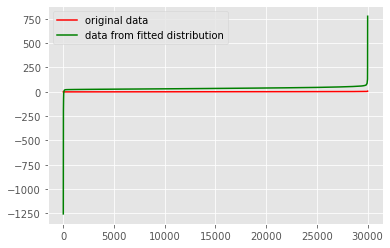

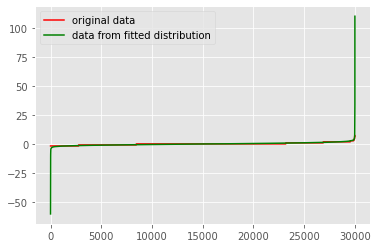

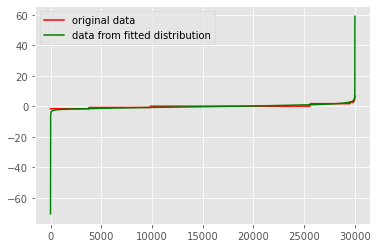

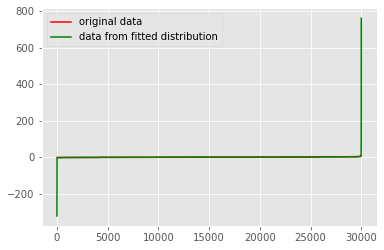

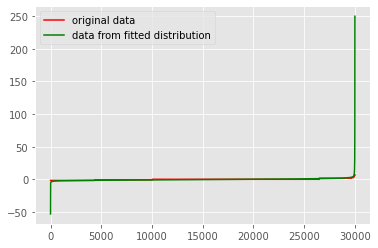

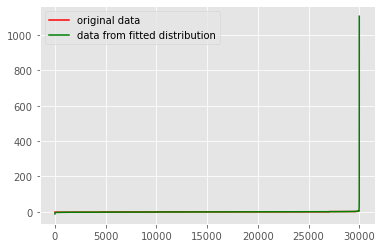

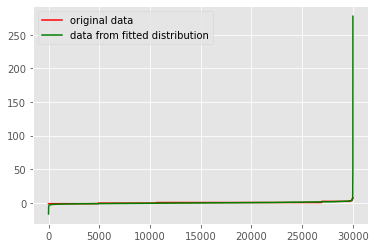

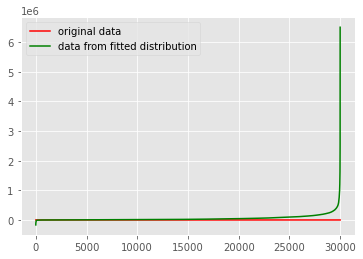

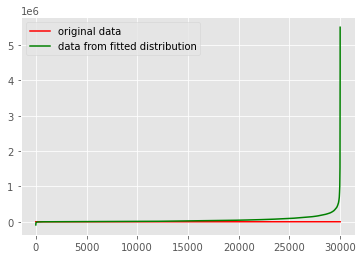

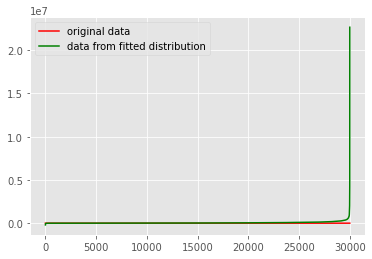

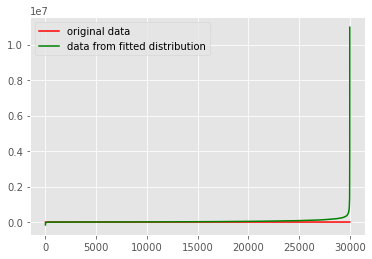

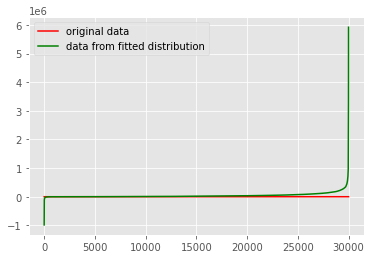

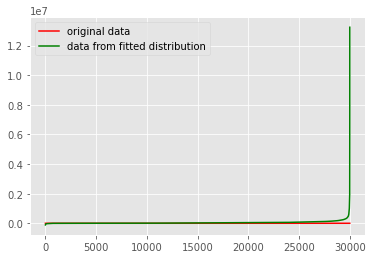

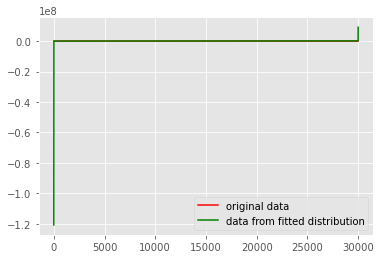

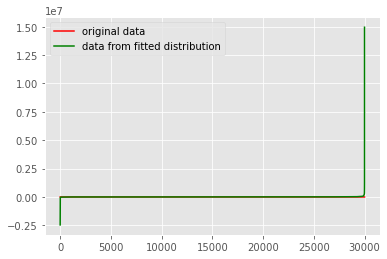

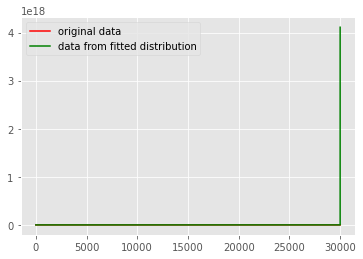

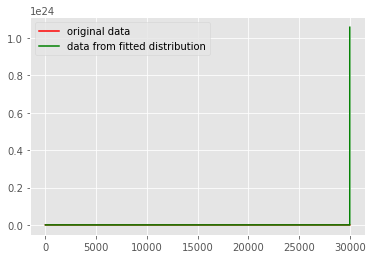

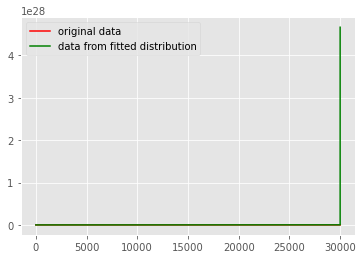

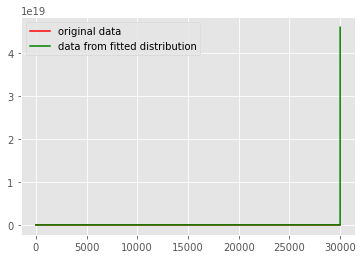

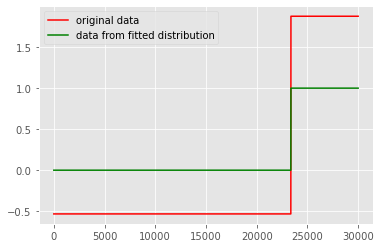

In [39]:
#plots
for column in data:
    sorted_data = np.sort(data[column])
    scaled = ((sorted_data-sorted_data.mean())/sorted_data.std())
    plt.plot(scaled, color = 'r', label = 'original data')
    plt.plot(np.sort(data_rec[column]), color = 'g', label = 'data from fitted distribution')
    plt.legend()
    plt.show()